In [1]:
import sys
sys.path.append('../../..')

In [2]:
%%bash
pip install -r requirements.txt

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from help_project.src.disease_model import base_model
from help_project.src.disease_model import data
from help_project.src.disease_model import ensemble_model
from help_project.src.disease_model.models import auquan_seir
from help_project.src.disease_model.models import sir
from help_project.src.disease_model.utils import data_fetcher

In [4]:
fetcher = data_fetcher.DataFetcher()
country = 'India'

population_data = fetcher.get_population_data(country)
health_data = fetcher.get_health_data(country)

In [5]:
cutoff_date = '2020-05-20'
fit_days = 20

past_health_data = data.HealthData(
    confirmed_cases=health_data.confirmed_cases.loc[:cutoff_date][-fit_days:],
    recovered=health_data.recovered.loc[:cutoff_date][-fit_days:],
    deaths=health_data.deaths.loc[:cutoff_date][-fit_days:],
)
past_policy = data.PolicyData(lockdown=np.zeros_like(past_health_data.confirmed_cases))

future_health_data = data.HealthData(
    confirmed_cases=health_data.confirmed_cases.loc[cutoff_date:],
    recovered=health_data.recovered.loc[cutoff_date:],
    deaths=health_data.deaths.loc[cutoff_date:],
)
future_policy = data.PolicyData(
    lockdown=pd.Series(index=future_health_data.confirmed_cases.index,
                       data=np.zeros_like(future_health_data.confirmed_cases)))

In [6]:
sir_model = sir.SIR()
sir_model.fit(population_data, past_health_data, past_policy)
sir_model.get_params()

{'beta': 0.09671432869092822,
 'gamma': 0.03334017521519768,
 'b': 0.3640895279338546,
 'mu': 8.917067314488674e-05,
 'mu_i': 0.03984641667183672,
 'cfr': 0.04982052976198004}

In [7]:
predictions = sir_model.predict(population_data, past_health_data, future_policy)

In [8]:
def Visualize(title, past_data, predictions, ground_truth=None):
    past_df = pd.DataFrame({'date': past_data.index.strftime('%Y-%m-%d'),
                            'past': past_data})
    future_data = {'date': predictions.index.strftime('%Y-%m-%d'),
                   'predictions': predictions}
    if ground_truth is not None:
        future_data['ground_truth'] = ground_truth
    future_df = pd.DataFrame(future_data)
    data = pd.concat([past_df, future_df])    
    dates = data['date']

    melt = data.melt(id_vars=['date'], 
                     var_name='data', 
                     value_name='value')
    fig, ax = plt.subplots(figsize = (12,6))
    ax = sns.pointplot(x='date', y='value', data=melt, hue='data')
    ax.set_title(title)
    ax.set_xticklabels(labels=dates, rotation=45, ha='right')
    good_tick_count = 15
    if len(dates) > good_tick_count:
        n = len(dates) // good_tick_count
        for ind, label in enumerate(ax.get_xticklabels()):
            if ind % n == 0:  # every nth label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    return ax

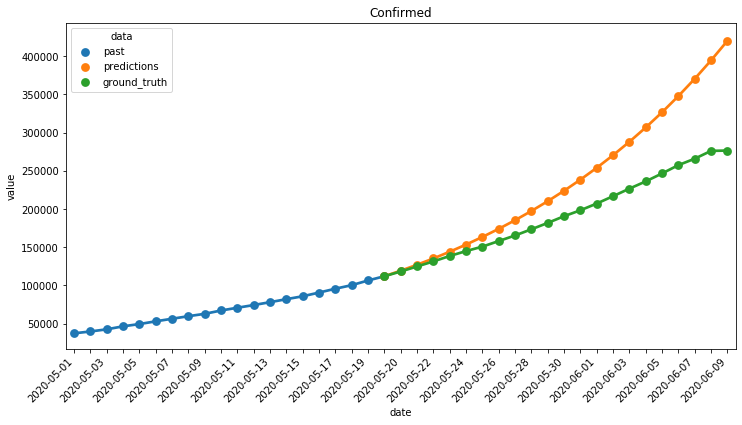

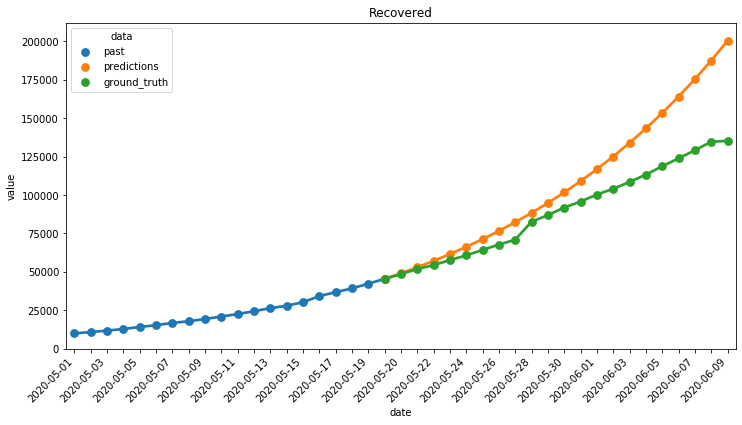

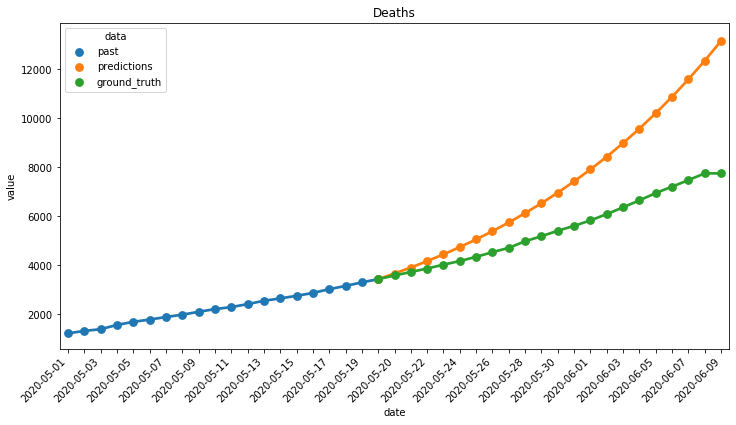

In [9]:
_ = Visualize('Confirmed',
              past_health_data.confirmed_cases,
              predictions.confirmed_cases,
              future_health_data.confirmed_cases)

_ = Visualize('Recovered',
              past_health_data.recovered,
              predictions.recovered,
              future_health_data.recovered)

_ = Visualize('Deaths',
              past_health_data.deaths,
              predictions.deaths,
              future_health_data.deaths)

In [10]:
auquan_model = auquan_seir.AuquanSEIR()
auquan_model.fit(population_data, past_health_data, past_policy)
auquan_model.get_params()

{'res': array([2.37745302e-01, 1.31667416e-01, 2.08289048e-04, 6.71251020e-02,
        5.85741583e-02, 3.64151932e-02, 1.60580346e+07, 9.84444739e+08,
        1.37691488e+07]),
 'startE': 26426926.850044478,
 'startS': 920607049.2392982,
 'startIu': 40534629.63978999,
 'startCu': 28024544.446865804,
 'initial_time': Timestamp('2020-05-07 00:00:00')}

In [11]:
auquan_predictions = auquan_model.predict(population_data, past_health_data, future_policy)

(susceptible0, exposed0, infected_unreported0,             infected_reported0, deaths0, cured0, cured_unreported0), population
(920607049, 26426926, 40534629, 63172, 3434, 45422, 4053462) 991734094


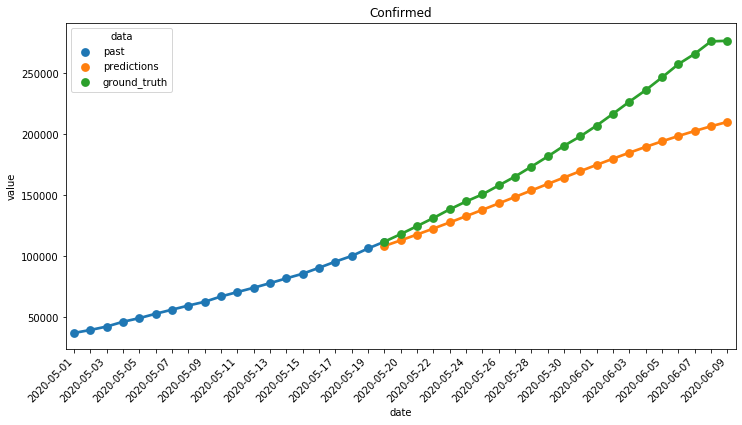

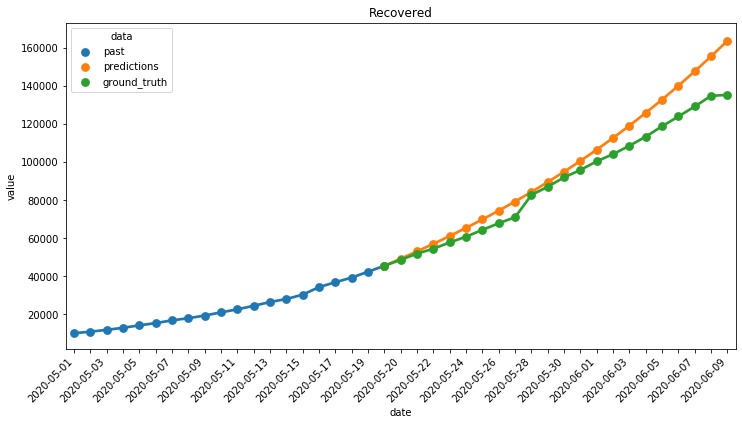

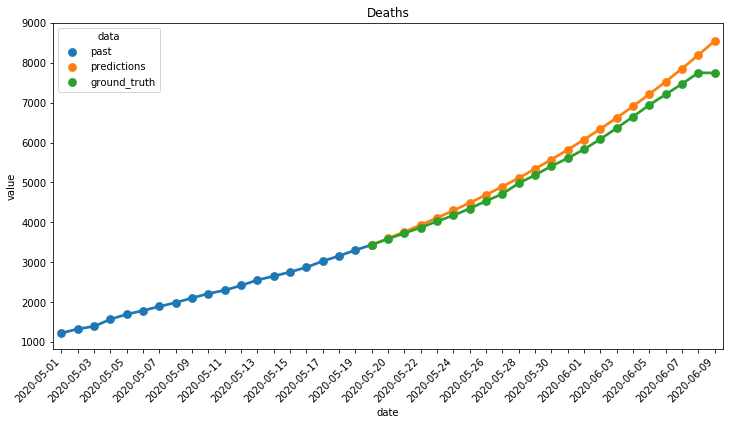

In [12]:
_ = Visualize('Confirmed',
              past_health_data.confirmed_cases,
              auquan_predictions.confirmed_cases,
              future_health_data.confirmed_cases)

_ = Visualize('Recovered',
              past_health_data.recovered,
              auquan_predictions.recovered,
              future_health_data.recovered)

_ = Visualize('Deaths',
              past_health_data.deaths,
              auquan_predictions.deaths,
              future_health_data.deaths)

In [13]:
ensemble = ensemble_model.EnsembleModel([sir_model, auquan_model])
# ensemble.fit(population_data, past_health_data, past_policy)  # Not needed - already fit

In [14]:
ensemble_predictions = ensemble.predict(population_data, past_health_data, future_policy)

(susceptible0, exposed0, infected_unreported0,             infected_reported0, deaths0, cured0, cured_unreported0), population
(920607049, 26426926, 40534629, 63172, 3434, 45422, 4053462) 991734094


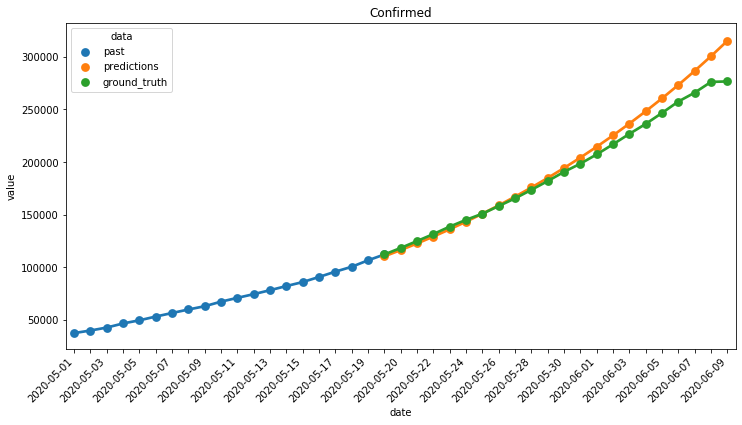

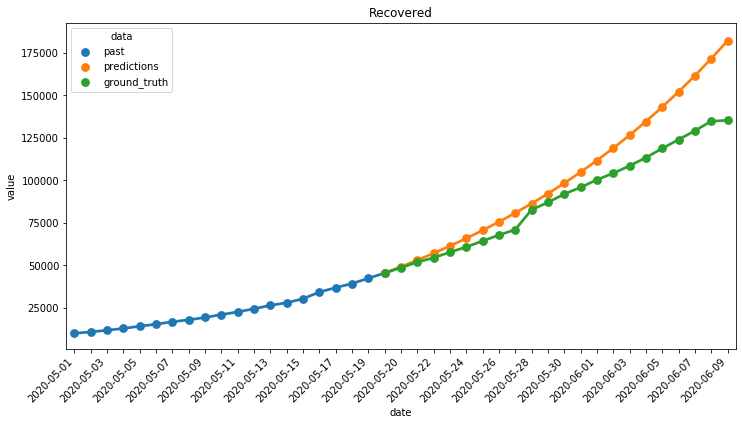

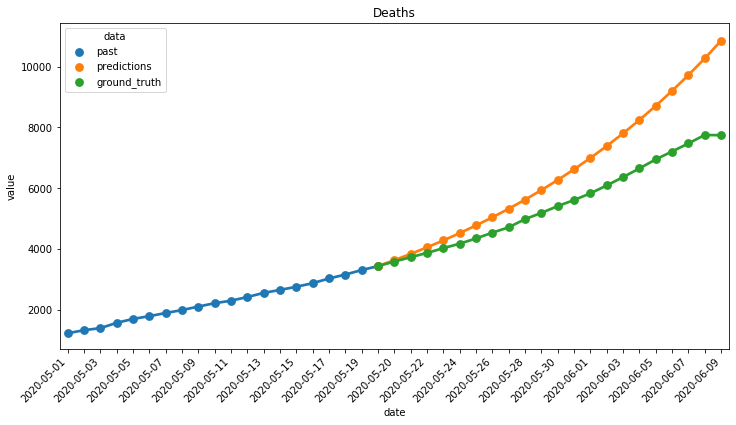

In [15]:
_ = Visualize('Confirmed',
              past_health_data.confirmed_cases,
              ensemble_predictions.confirmed_cases,
              future_health_data.confirmed_cases)

_ = Visualize('Recovered',
              past_health_data.recovered,
              ensemble_predictions.recovered,
              future_health_data.recovered)

_ = Visualize('Deaths',
              past_health_data.deaths,
              ensemble_predictions.deaths,
              future_health_data.deaths)